I was once having a conversation with one of my friend on why everything is square patches generation when most of the images/videos in realworld are either potrait or landscape with varied aspect ratio with different resolution. I didn't give it much of a thought then but [OpenAI SORA technical paper](https://openai.com/research/video-generation-models-as-world-simulators#fn-18) has sections about it called 
- `Variable durations, resolutions, aspect ratios`. 
- `Improved framing and composition`

of the 32 papers added as refrences, [`Patch n'Pack: NaViT, a Vision Transformer for any Aspect Ratio and Resolution.`](https://arxiv.org/pdf/2307.06304.pdf) discusses about how we can deal with this. This blogs is about understanding  how a transformer model can sample widescreen 1920x1080p images, vertical 1080x1920 images and everything inbetween. 

To start with, this topic is not new to the deep learning community, In the initial days when beating imagenet benchmark is the rage, square crops are common as most of the images are iconic in nature and a central square crop would actually capture a lot of details in the image. Often times to improve accuracy, practioners used to do test-time augumentation by randomly cropping multiple image crops and then aggregating the results. Training on native resolutions came into existence with object detection, here objects are spread across the image and this pose two problems. 
- random crop would strip off some objects.
- resize would deform the objects.

So, All object detection models have seen massive improvements when the models are trained on their native image resolution. The process is something as below. 
- Sort all the images based on aspect ratio
- group them into batches. 
- pick one batch randomly.
- resize images by preserving aspect ratio to required resolution (variable)
- pad images to bring them all to the same size.
- forward pass through a conv network and calculate loss. 

As we have seen, For conv networks this is straight forward step without any architectural changes. The cavet is that we have to processes the masked portion of the image too and that is lost computation & we cannot do anything about it. for transformers this is different and the following are the things we have to take care off.
- If the image_sizes changes, the number of patches changes, How do we make sure that positional embeddings are added to these variable patches effectively?
- when we pad an image and generate tokens, it is un-necessary to calculate attention between them, How do we mask it?

The authors of `Patch n Pack` has suggested doing. 
- Masked self attention
- Factorized & fractional positional embeddings

We will discuss in detail about these two topics in this blog. Lets bring our `coco-val` set and perform operations on it. 

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import fastcore.all as fc
import torchvision.transforms.functional as F
import fastcore.all as fc

from tqdm import tqdm
from PIL import Image
from functools import partial
from torchvision.transforms import Resize, RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor, ToPILImage, Pad

import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

> Lets create an image with longest size as 768. The patch size is 32

In [ ]:
img_size = 768
patch_size = 32

## load and calculate aspect ratios

we load and use `coco val` data. we can also load anyother dataset.

In [ ]:
imgs = fc.L(fc.Path("coco/val2017/").glob("*.jpg"))
imgs

(#5000) [Path('coco/val2017/000000182611.jpg'),Path('coco/val2017/000000335177.jpg'),Path('coco/val2017/000000278705.jpg'),Path('coco/val2017/000000463618.jpg'),Path('coco/val2017/000000568981.jpg'),Path('coco/val2017/000000092416.jpg'),Path('coco/val2017/000000173830.jpg'),Path('coco/val2017/000000476215.jpg'),Path('coco/val2017/000000479126.jpg'),Path('coco/val2017/000000570664.jpg')...]

In [ ]:
img_sizes = np.asarray([Image.open(i).size for i in tqdm(imgs)])
img_sizes.shape

100%|████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5238.41it/s]


(5000, 2)

In [ ]:
ar = img_sizes[:, 0]/img_sizes[:, 1]
ar.shape

(5000,)

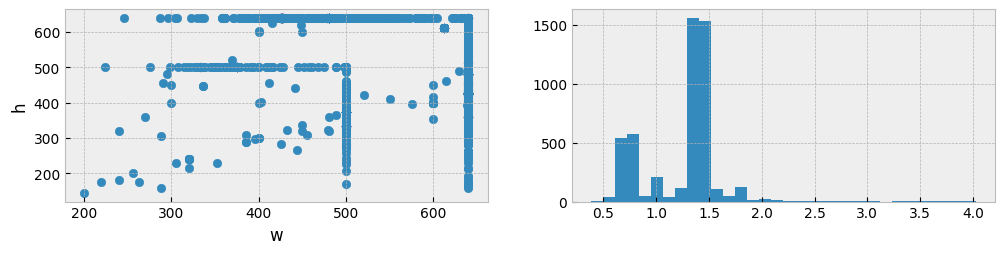

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2.5), nrows=1, ncols=2)
ax.flat[0].scatter(img_sizes[:, 0], img_sizes[:, 1])
ax.flat[0].set_xlabel("w")
ax.flat[0].set_ylabel("h")

ax.flat[1].hist(ar, bins=32)

plt.show()

In [ ]:
(ar[(ar>=0.75) & (ar<=1.25)].shape[0]/ar.shape[0])*100

17.82

> Roughly 18% of the image fall within [0.75, 1.25] aspect ratio which we can consider as square. we have varied aspect ratios

Now lets order the images based on apsect ratio

In [ ]:
nimgs = imgs[ar.argsort()]
nimgs

(#5000) [Path('coco/val2017/000000042102.jpg'),Path('coco/val2017/000000452515.jpg'),Path('coco/val2017/000000342971.jpg'),Path('coco/val2017/000000511760.jpg'),Path('coco/val2017/000000289516.jpg'),Path('coco/val2017/000000067534.jpg'),Path('coco/val2017/000000206271.jpg'),Path('coco/val2017/000000500478.jpg'),Path('coco/val2017/000000031817.jpg'),Path('coco/val2017/000000485027.jpg')...]

> Lets chunk the images 

In [ ]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]
        
bimgs = fc.L(chunks(nimgs, sz=4))
bimgs

(#1250) [[Path('coco/val2017/000000042102.jpg'), Path('coco/val2017/000000452515.jpg'), Path('coco/val2017/000000342971.jpg'), Path('coco/val2017/000000511760.jpg')],[Path('coco/val2017/000000289516.jpg'), Path('coco/val2017/000000067534.jpg'), Path('coco/val2017/000000206271.jpg'), Path('coco/val2017/000000500478.jpg')],[Path('coco/val2017/000000031817.jpg'), Path('coco/val2017/000000485027.jpg'), Path('coco/val2017/000000244496.jpg'), Path('coco/val2017/000000536038.jpg')],[Path('coco/val2017/000000125952.jpg'), Path('coco/val2017/000000505573.jpg'), Path('coco/val2017/000000308531.jpg'), Path('coco/val2017/000000466339.jpg')],[Path('coco/val2017/000000052591.jpg'), Path('coco/val2017/000000221281.jpg'), Path('coco/val2017/000000117744.jpg'), Path('coco/val2017/000000354072.jpg')],[Path('coco/val2017/000000341058.jpg'), Path('coco/val2017/000000173044.jpg'), Path('coco/val2017/000000110999.jpg'), Path('coco/val2017/000000068078.jpg')],[Path('coco/val2017/000000060899.jpg'), Path('coc

In [ ]:
bimg = bimgs[np.random.randint(len(bimgs))]
bimg

(#4) [Path('coco/val2017/000000121497.jpg'),Path('coco/val2017/000000546823.jpg'),Path('coco/val2017/000000109441.jpg'),Path('coco/val2017/000000153011.jpg')]

## Transforms. 

We will write our own resize function and pad the image to nearest 32 multiple. First we will see if h or w is large and resize that dimension to it. Then lets resize the other dim preserving the aspect ratio. pad both the dimension to nearest mutliple of patch_size. 

```
!pip install albumentations
```

In [ ]:
from albumentations import LongestMaxSize
from albumentations import PadIfNeeded

In [ ]:
image = Image.open(bimg[3])

In [ ]:
resize_img = LongestMaxSize(max_size=768)(image=np.asarray(image))
resize_img["image"].shape

(576, 768, 3)

In [ ]:
padded_img = PadIfNeeded(min_width=None, min_height=None, pad_width_divisor=patch_size, pad_height_divisor=patch_size)(**resize_img)
padded_img["image"].shape

(576, 768, 3)

In [ ]:
class ResizeAndPad:
    def __init__(self, patch_size, max_size=768):
        fc.store_attr()
        self.resize_img = LongestMaxSize(max_size=768)
        self.pad_img = PadIfNeeded(min_width=None, min_height=None, pad_width_divisor=patch_size, pad_height_divisor=patch_size)
        
    __repr__ = fc.basic_repr(flds="patch_size, max_size")
    
    def __call__(self, img):
        img = self.resize_img(image=img)["image"]
        img = self.pad_img(image=img)["image"]
        return img

In [ ]:
rp=ResizeAndPad(patch_size, max_size=768)
rp

__main__.ResizeAndPad(patch_size=32, max_size=768)

In [ ]:
bimg = bimgs[np.random.randint(len(bimgs))]
timg = [rp(np.asarray(Image.open(i))) for i in bimg]
[i.shape for i in timg]

[(576, 768, 3), (576, 768, 3), (576, 768, 3), (576, 768, 3)]

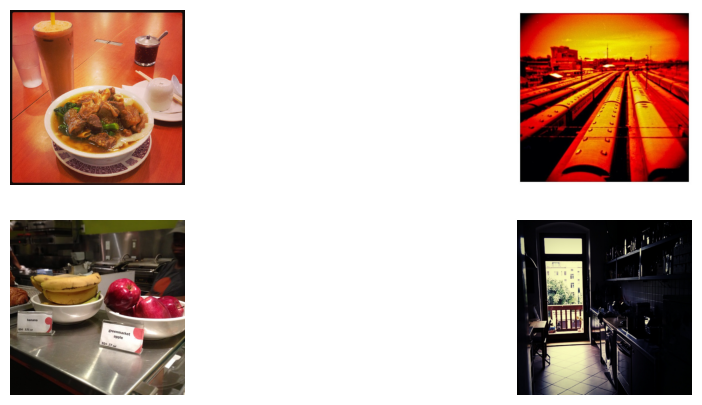

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5), nrows=2, ncols=2)
for n, i in enumerate(timg):
    ax.flat[n].imshow(i)
    ax.flat[n].axis("off")
plt.show()

## Patch Embed

we will create patch embeddings for [3x32x32]. For this we can use a simple convolution layer with kernel and stride as patch_size

In [ ]:
timg = [torch.from_numpy(x).float().permute((2, 0, 1)).unsqueeze(0) for x in timg]
[i.shape for i in timg]

[torch.Size([1, 3, 576, 768]),
 torch.Size([1, 3, 576, 768]),
 torch.Size([1, 3, 576, 768]),
 torch.Size([1, 3, 576, 768])]

In [ ]:
pe = nn.Conv2d(3, 768, kernel_size=patch_size, stride=patch_size)
pe

Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))

In [ ]:
out = [pe(i).flatten(2).transpose(1, 2) for i in timg]
[i.shape for i in out]

[torch.Size([1, 432, 768]),
 torch.Size([1, 432, 768]),
 torch.Size([1, 432, 768]),
 torch.Size([1, 432, 768])]

## Positional embedding 

In the paper, its mentioned that, For parametric positional embeddings we followed `Tancik et al. (2020)` and used Fourier embeddings. Specifically, coordinates (x, y) were mapped using a single linear layer before applying sin and cos activations to them, and stacking the results to obtained the positional embeddings.


<img src="images/fractional_pe.png" width=400 height=400>

we take a slightly different approch here and use `segment-anything` point prompt encoding here.
- for each image, we get centers of all the patches and scale them using max(w, h)
- then pass it through a linear layer
- then we use sin cos on each embedding vector and concat them 

In [ ]:
w, h = timg[0].shape[2:]
x = torch.arange(0, w, patch_size)
y = torch.arange(0, h, patch_size)
X, Y = torch.meshgrid(x, y)
centers = torch.stack((X.flatten(), Y.flatten()), dim=1)
centers = centers+(patch_size/2)
centers.shape

torch.Size([432, 2])

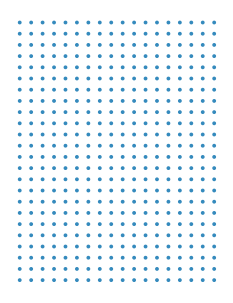

In [ ]:
fig, ax = plt.subplots(figsize=(2.76, 3.68))
ax.scatter(centers[:, 0].numpy(), centers[:, 1].numpy(), marker='o', linestyle='', s=3)
ax.axis("off")
plt.show()

In [ ]:
fractional = centers/max(w, h)
fractional.shape

torch.Size([432, 2])

In [ ]:
pe = nn.Linear(2, 768//2)
pe_out = pe(fractional)
pe_out.shape

torch.Size([432, 384])

In [ ]:
pe_out = 2* torch.pi * pe_out
pe_out

tensor([[-2.0788, -3.7223,  3.9530,  ...,  2.5841, -1.6629, -0.9774],
        [-2.0767, -3.8039,  3.9853,  ...,  2.4336, -1.6239, -0.8696],
        [-2.0746, -3.8855,  4.0176,  ...,  2.2831, -1.5850, -0.7618],
        ...,
        [-0.5127, -7.0926,  3.9715,  ..., -2.7499, -1.9459,  3.4507],
        [-0.5106, -7.1742,  4.0038,  ..., -2.9004, -1.9069,  3.5585],
        [-0.5085, -7.2558,  4.0360,  ..., -3.0508, -1.8680,  3.6663]],
       grad_fn=<MulBackward0>)

In [ ]:
pe_out = torch.cat([torch.sin(pe_out), torch.cos(pe_out)], dim=-1)
pe_out.shape

torch.Size([432, 768])

In [ ]:
(out[0] + pe_out.unsqueeze(0)).shape

torch.Size([1, 432, 768])

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, patch_size):
        super().__init__()
        self.embed_size = embed_size
        self.patch_size = patch_size
        self.pe = nn.Linear(2, embed_size)
    
    def forward(self, img_size):
        w, h = img_size 
        x = torch.arange(0, w, self.patch_size)
        y = torch.arange(0, h, self.patch_size)
        X, Y = torch.meshgrid(x, y)
        centers = torch.stack((X.flatten(), Y.flatten()), dim=1)
        centers = centers+(patch_size/2)
        
        fractional = centers/max(w, h)
        pe_out = self.pe(fractional)
        pe_out = 2* torch.pi * pe_out
        pe_out = torch.cat([torch.sin(pe_out), torch.cos(pe_out)], dim=-1)
        return pe_out

## Combining embedding and positional encoding 

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, in_chns, embed_size, patch_size):
        super().__init__()
        self.embed = nn.Conv2d(in_chns, embed_size, kernel_size=patch_size, stride=patch_size)
        self.pe = PositionalEncoding(embed_size//2, patch_size)
    
    def forward(self, x):
        #x is list of images in tensor format [1, 3, W, H]
        out = []
        for img in x:
            t = self.embed(img).flatten(2).transpose(1, 2)
            w, h = img.shape[2:]
            p = self.pe((w, h))
            out.append(t+p.unsqueeze(0))
        return out

In [ ]:
def img_list_reader(x):
    timg = [rp(np.asarray(Image.open(i))) for i in x]
    timg = [torch.from_numpy(x).float().permute((2, 0, 1)).unsqueeze(0) for x in timg]
    return timg

In [ ]:
idx = 386 #np.random.randint(len(bimgs)) #386
bimg = bimgs[idx]
imgs = img_list_reader(bimg)
[i.shape for i in imgs], idx

([torch.Size([1, 3, 640, 768]),
  torch.Size([1, 3, 640, 768]),
  torch.Size([1, 3, 608, 768]),
  torch.Size([1, 3, 608, 768])],
 386)

In [ ]:
pe = PatchEmbed(3, 768, patch_size)
pe

PatchEmbed(
  (embed): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (pe): PositionalEncoding(
    (pe): Linear(in_features=2, out_features=384, bias=True)
  )
)

In [ ]:
out = pe(imgs)
[i.shape for i in out]

[torch.Size([1, 480, 768]),
 torch.Size([1, 480, 768]),
 torch.Size([1, 456, 768]),
 torch.Size([1, 456, 768])]

> Since everyimage has different sequence length, lets pad all the sequences to same length. we can use torch rnn utils pad_sequence for this  

In [ ]:
from torch.nn.utils.rnn import pad_sequence
pout = pad_sequence([i.squeeze(0) for i in out], batch_first=True)
pout.shape

torch.Size([4, 480, 768])

> this is the tensor which we can pass through transformer layers and get the output.

it is un-neccessary to calculate attention between two padded sequences. `torch.nn.functional.scaled_dot_product_attention` has `attn_mask` which will make sure that attn between masked portions is not calculated. we will see how to generate this mask below 

> First lets create a mask and fill it with zeros where-ever squence is padded. in the example about we have image3 and image 4 padded with 24 sequences. 

In [ ]:
mask = torch.ones(pout.shape[:2])
mask.shape

torch.Size([4, 480])

In [ ]:
for n, i in enumerate(out): mask[n, i.shape[1]:] = 0

In [ ]:
mask.sum(axis=(1))

tensor([ 0.,  0., 24., 24.])

> calculate the q, k, v values of the model. 

In [ ]:
B, T, C = pout.shape
head_size = 768
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(pout)
q = query(pout)
v = value(pout)
# scale_factor = 1 / math.sqrt(q.size(-1)) 
# qk = q@k.transpose(-2, -1) * scale_factor #(B, T, 16) @ (B, 16, T) --. B, T, T
# qk.shape
q.shape, k.shape, v.shape

(torch.Size([4, 480, 768]),
 torch.Size([4, 480, 768]),
 torch.Size([4, 480, 768]))

> since q and k are of shape (4, 480, 768) x (4, 480, 768).the attention matrix will have shape of (4, 480, 480). so we need to expand our attention mask along the x-direction so that is is also of the shape (4, 480, 480). below is an image, we can see that 3 & 4 images in the batch has some sequences masked with zeros. 

In [ ]:
mask_ = torch.repeat_interleave(mask.unsqueeze(-1), 480, dim=2)#.unsqueeze(1)
mask_.shape

torch.Size([4, 480, 480])

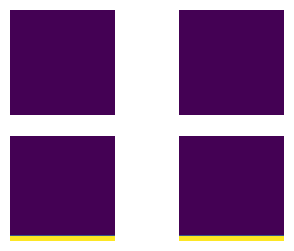

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), nrows=2, ncols=2)
for m_ in range(mask_.shape[0]):
    ax.flat[m_].imshow(np.uint8(255*(~mask_[m_].bool()).numpy()))
    ax.flat[m_].axis("off")
plt.show()

> lets do the attention

In [ ]:
%%time
torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=mask_.bool()).shape

CPU times: user 23.1 ms, sys: 4.8 ms, total: 27.9 ms
Wall time: 20.8 ms


torch.Size([4, 480, 768])

In [ ]:
%%time
torch.nn.functional.scaled_dot_product_attention(q, k, v).shape

CPU times: user 22.4 ms, sys: 5.81 ms, total: 28.3 ms
Wall time: 19.4 ms


torch.Size([4, 480, 768])

## End notes 
- NaViT is implemented in [vit_pytorch](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/na_vit.py)
- even though we used a list of images and creating sequences using a for loop for each image. less than 2% of the images in the batches we created have varied image sizes inside a batch. so we can batch them if they are all the same shape. 
- Fractional positional emebedding is the key part and we used a simple network to generate them as per image dimension. This also is done using a for loop in our case, we can use batch if all the images are of the same shape. 
-  There is no significant performance in terms of speed because the padded sequences in this case is super small.

finally this is a way to process images of varied shapes with minimum computational overhead. 